In [1]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.metrics import edit_distance

from transformers import AutoTokenizer

random.seed(6)
np.random.seed(6)


# Experiment 6 - MCQ Long answer HTML tags

For this experiment I changed the system prompt, asking the LLM to generate more text (about "thinking") and then give the final answer.


**Parameters:**
- model: llama3.1:8b
- system prompt: MCQ_system_prompt_v3.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)
- the output is limited to 128 tokens (shouldn't influence the results, it only cutoffs the generation)


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [2]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,choices,num,text
id,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...
Feasibility_T6_1453,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


Loading the responses from the LLM

In [3]:
# needed to modify the output file because of the bug
# I introduced in the code
predictions = []
with open('../outputs/responses_llama3.1:8b_20250219_13:49:44.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,answer
id,
Interaction_T1_13,<Reasoning> To determine which object was tidi...
Interaction_T1_14,<Reasoning> To determine which object was tidi...
Interaction_T1_31,<Reasoning> To determine which object was thro...
Interaction_T1_32,<Reasoning> To determine which object was put ...
Interaction_T1_40,<Reasoning> The question asks which object was...
...,...
Feasibility_T6_1453,<Reasoning> The person is initially seen holdi...
Feasibility_T6_1454,<Reasoning> The person is initially standing i...
Feasibility_T6_1455,<Reasoning> The person is initially standing i...


In [4]:
predictions_df.iloc[0:20]['answer'].apply(print)


<Reasoning>
To determine which object was tidied up by the person, we need to analyze the sequence of Scene-Graphs and identify any changes or actions taken on specific objects.

Looking at the first few Scene-Graphs, we see that the person is initially standing next to the clothes. In the second Scene-Graph, the person moves in front of the clothes, indicating a change in position but not necessarily an action on the object itself.

However, as we progress through the sequence, we notice that the person starts holding the clothes (indicated by "person - holding - clothes") and then also holds the blanket ("person - holding - blanket"). This suggests that the person is actively engaging with both objects.

The key moment comes in Scene-Graph 14, where the person is holding the towel, but more importantly, they are also beneath the clothes. This implies that the person has moved the clothes to a new location or position, which can be interpreted as tidying up the object.

Considering th

id
Interaction_T1_13     None
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_32     None
Interaction_T1_40     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_71     None
Interaction_T1_76     None
Interaction_T1_78     None
Interaction_T1_81     None
Interaction_T1_95     None
Interaction_T1_100    None
Interaction_T1_101    None
Interaction_T1_104    None
Interaction_T1_106    None
Interaction_T1_111    None
Interaction_T1_137    None
Interaction_T1_139    None
Interaction_T1_147    None
Name: answer, dtype: object

In [5]:
# Check if the the template is somewhere in the answer
html_tags_pattern = r'<Final answer>\s*A:\s*\d\.\s*((?:\w+(?:\s|\/)?){,10}\.)\s*</Final answer>'
html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


print(f"Answer following the template: {html_tags_mask.value_counts()[True]}\n"
      f"{html_tags_mask.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {html_tags_mask.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 5038
70.98% of the total

Only 2060 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_53813/447578442.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  html_tags_mask = predictions_df['answer'].str.contains(html_tags_pattern, case=False, regex=True)


Let's start by viewing how many answers follow the template:

In [6]:
# Check if the the template is somewhere in the answer
#
# An example of the template expressed by the regex is: A: 1. The answer.
# where the number followed by a dot is optional
ans_regex_pattern = r'A:\s*(?:\d\.)?\s*((?:\w+(?:\s|\/)?){,10}\.)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.size:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


/tmp/ipykernel_53813/2545864474.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, case=False, regex=True, flags=re.DOTALL)


Answer following the template: 6543
92.18% of the total

Only 555 samples do not contain the answer in the response with the specified format


In [7]:
# Check that contains answer is subset of html_tags
assert (html_tags_mask & contains_answer).sum() == html_tags_mask.sum()


## Non-conforming responses

In [8]:
predictions_df.loc[~html_tags_mask].iloc[:5]['answer'].apply(lambda x: print(x, '\n\n'))


<Reasoning>
To determine which object was tidied up by the person, we need to analyze the sequence of Scene-Graphs and look for any relationships that indicate an action of tidying or cleaning.

In the first Scene-Graph, the person is holding a towel, in front of a towel, holding clothes, in front of clothes, holding a blanket, and in front of a blanket. This suggests that the person is initially holding multiple objects (towel, clothes, and blanket) and placing them in front of themselves.

In subsequent Scene-Graphs, we see the person touching or holding individual objects, such as towels, clothes, and blankets. However, there is no clear indication of tidying up or cleaning a specific object.

The key insight comes from analyzing the relationships between the objects and the person's actions. In several Scene-Graphs, the person is in front of multiple objects (towel, clothes, and blanket), which suggests that they are organizing or arranging these items.

However, there is one Scene

id
Interaction_T1_14     None
Interaction_T1_31     None
Interaction_T1_43     None
Interaction_T1_70     None
Interaction_T1_111    None
Name: answer, dtype: object

In [9]:
predictions_df.loc[~contains_answer].iloc[:100]['answer'].apply(lambda x: print(x, '\n\n'))


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


Error while generating the response. Look at the logs. 


<Reasoning>
To determine which object was sat at by the person, I will analyze the Spatio-Temporal Scene Graph (STSG) for any relationships between the person and objects that indicate sitting.

In the STSG, there are several instances where the person is in front of or touching a table. However, to confirm if the person is sitting on the table, I need to look for relationships that indicate sitting, such as "on" or "sitting_on".

Upon reviewing the STSG, I found that in some frames, the person is described as being behind the refrigerator and in front of the table (e.g., ['person - in_f

id
Interaction_T1_172     None
Interaction_T1_239     None
Interaction_T1_264     None
Interaction_T1_299     None
Interaction_T1_522     None
                       ... 
Interaction_T3_4955    None
Interaction_T3_5129    None
Interaction_T3_5138    None
Interaction_T3_5523    None
Interaction_T3_5668    None
Name: answer, Length: 100, dtype: object

In [10]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)


In [11]:
resp_token_len = pd.Series(index=predictions_df.index)

for index, row in predictions_df.iterrows():
    resp_token_len.loc[index] = len(tokenizer.encode(row['answer']))

resp_token_len.sort_values().value_counts(sort=False)


/tmp/ipykernel_53813/4005420109.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  resp_token_len = pd.Series(index=predictions_df.index)


12.0      543
67.0        1
71.0        1
73.0        2
75.0        1
         ... 
1581.0      1
1678.0      1
1844.0      1
2623.0      1
4757.0      1
Length: 625, dtype: int64

The responses with a token length of 12 are those that caused an error during generation (mainly due to time-out 4mins):

In [12]:
(predictions_df[resp_token_len == 12] == "Error while generating the response. Look at the logs.").all()


answer    True
dtype: bool

In [13]:

print(f"Number of responses that are not conformat to the regex: {predictions_df[~contains_answer].shape[0]}")
print(f"Number of responses that took too long to answer:        {(resp_token_len == 12).sum()}")


Number of responses that are not conformat to the regex: 555
Number of responses that took too long to answer:        543


In [14]:
predictions_df[(~contains_answer) & ~(resp_token_len == 12)]['answer'].apply(lambda x: print(x, '\n\n'))


<Reasoning>
To determine which object was sat at by the person, I will analyze the Spatio-Temporal Scene Graph (STSG) for any relationships between the person and objects that indicate sitting.

In the STSG, there are several instances where the person is in front of or touching a table. However, to confirm if the person is sitting on the table, I need to look for relationships that indicate sitting, such as "on" or "sitting_on".

Upon reviewing the STSG, I found that in some frames, the person is described as being behind the refrigerator and in front of the table (e.g., ['person - in_front_of - table', 'person - behind - refrigerator']). However, this does not necessarily indicate sitting.

In other frames, the person is holding food or eating while touching the table (e.g., ['person - holding - sandwich', 'person - eating - sandwich', 'person - in_front_of - sandwich', 'person - holding - food', 'person - eating - food', 'person - touching - table', 'person - in_front_of - table']).

id
Interaction_T1_743     None
Interaction_T1_1897    None
Interaction_T4_1502    None
Sequence_T1_705        None
Sequence_T1_6556       None
Sequence_T3_1568       None
Sequence_T4_344        None
Sequence_T4_1297       None
Prediction_T1_38       None
Prediction_T2_605      None
Prediction_T2_786      None
Prediction_T4_1369     None
Name: answer, dtype: object

## Distribution of generated response lengths measured in tokens

count    7098.000000
mean      252.061285
std       155.152520
min        12.000000
25%       184.000000
50%       232.000000
75%       302.000000
max      4757.000000
dtype: float64

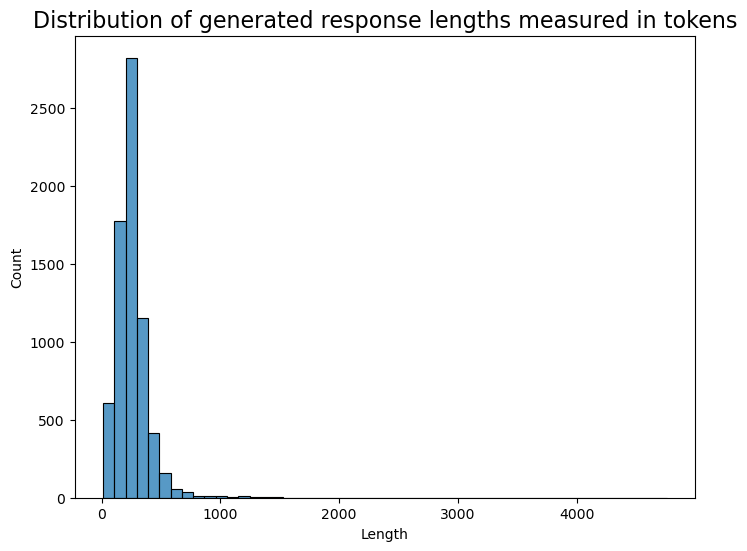

In [15]:
plt.figure(figsize=(8, 6))
sns.histplot(resp_token_len, bins=50)
plt.title("Distribution of generated response lengths measured in tokens", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")

resp_token_len.describe()


## Extracting the answers

Let's extract the the answers from the generated texts which do contain an answer:

In [16]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .to_frame(name='text')

ans_df
ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T1_13,The clothes.
Interaction_T1_14,The clothes.
Interaction_T1_31,The clothes.
Interaction_T1_32,The shoe.
Interaction_T1_40,The blanket.
...,...
Feasibility_T6_1453,Put down the phone/camera.
Feasibility_T6_1454,Throw the bag.
Feasibility_T6_1455,Wash the table.


In [17]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 442 unique answers


In [18]:
ans_df['text'].value_counts()


Took.                 408
Put down.             381
The clothes.          226
Opened.               218
The towel.            196
                     ... 
Took the shoes.         1
Threw the shoes.        1
5.                      1
Throw the blanket.      1
Throw the bag.          1
Name: text, Length: 221, dtype: int64

<AxesSubplot: xlabel='freq', ylabel='word'>

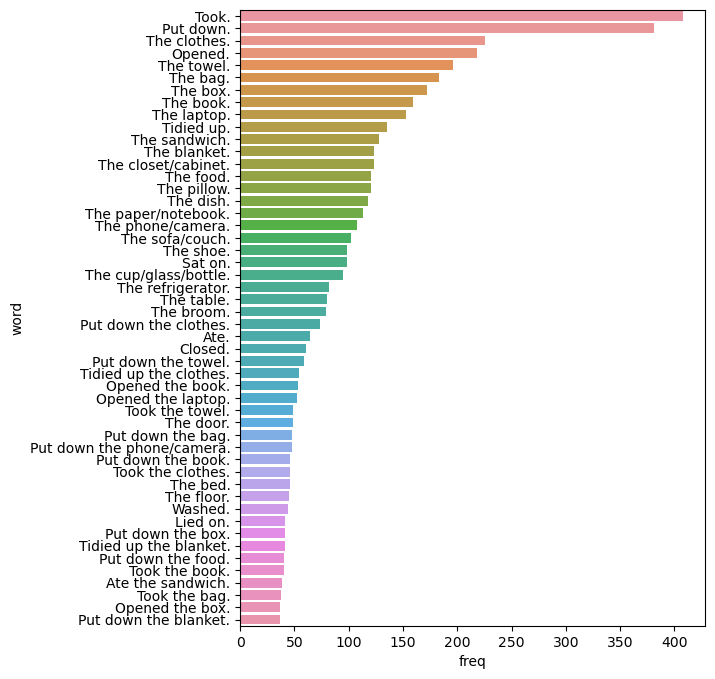

In [19]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [20]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


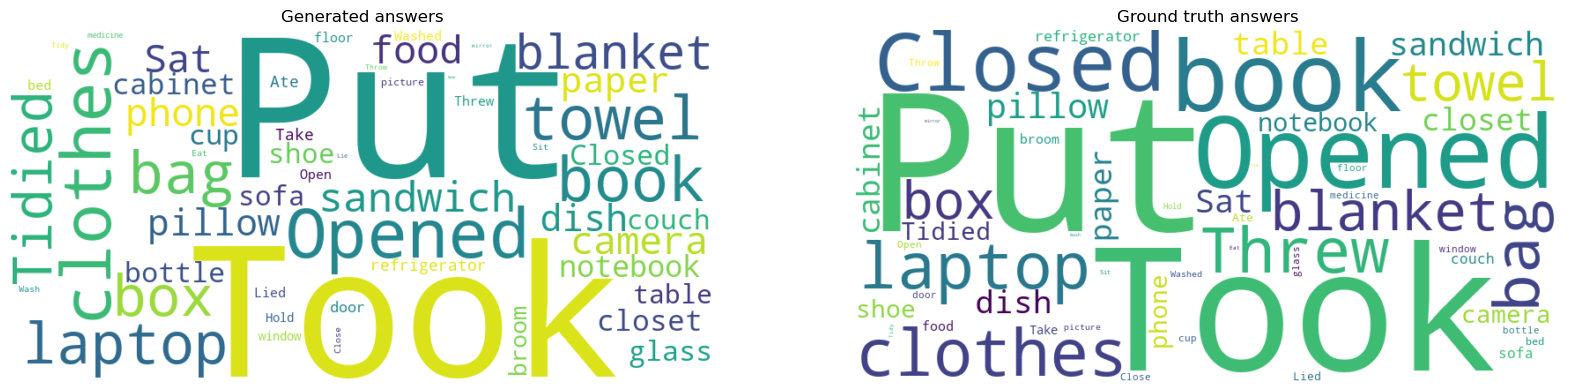

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

# predictions worldcloud
pred_text = ' '.join(ans_df['text'].astype(str))
wordcloud1 = WordCloud(width=800,
                       height=400,
                       background_color='white',
                       collocations=False).generate(pred_text)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('Generated answers')

# ground truth wordcloud 
gt_text = ' '.join(gt_df['text'].astype(str))
wordcloud2 = WordCloud(width=800,
                       height=400,
                       background_color='white', 
                       collocations=False).generate(gt_text)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('Ground truth answers')

plt.show()


<AxesSubplot: xlabel='freq', ylabel='word'>

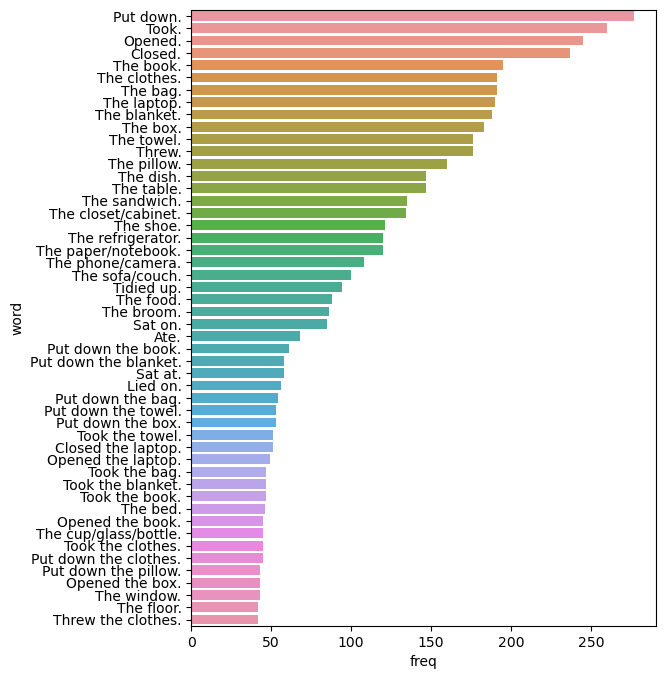

In [22]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [23]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(6543, 4)

In [24]:
eval_df['edit_distance'] = eval_df.apply(func=lambda row: edit_distance(row['text'], row['pred_text']), axis=1)

eval_df['edit_distance'].sort_values(ascending=True).value_counts(sort=False)


0     3884
1        1
2       21
3       35
4      384
5      278
6      252
7      558
8      331
9       50
10     108
11     113
12     123
13     116
14      60
15      58
16      28
17      35
18      26
19      28
20      25
21      13
22      10
23       5
24       1
Name: edit_distance, dtype: int64

In [25]:
eval_df[(eval_df['edit_distance'] > 0) & (eval_df['edit_distance'] < 3)]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_3745,"{'0': 'The door.', '1': 'The box.', '2': 'The ...",3,The book.,The box.,2
Interaction_T1_7146,"{'0': 'The bag.', '1': 'The box.', '2': 'The c...",1,The box.,The bag.,2
Sequence_T1_1586,"{'0': 'The book.', '1': 'The box.', '2': 'The ...",0,The book.,The box.,2
Sequence_T1_2084,"{'0': 'The book.', '1': 'The broom.', '2': 'Th...",0,The book.,The broom.,2
Sequence_T1_2567,"{'0': 'The closet/cabinet.', '1': 'The door.',...",2,The book.,The door.,2
Sequence_T1_7685,"{'0': 'The box.', '1': 'The bag.', '2': 'The p...",0,The box.,The bag.,2
Sequence_T2_904,"{'0': 'The book.', '1': 'The box.', '2': 'The ...",0,The book.,The box.,2
Sequence_T2_1500,"{'0': 'The box.', '1': 'The window.', '2': 'Th...",0,The box.,The bed.,2
Sequence_T2_1975,"{'0': 'The closet/cabinet.', '1': 'The door.',...",2,The book.,The door.,2


In [37]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


In [38]:
text_acc = accuracy(eval_df)

print(f"Text Accuracy: {text_acc:.2%}")


Text Accuracy: 59.36%


In [39]:
eval_df[eval_df['text'] == eval_df['pred_text']]


,choices,num,text,pred_text,edit_distance
id,,,,,
Interaction_T1_13,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.,The clothes.,0
Interaction_T1_14,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.,The clothes.,0
Interaction_T1_31,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.,The clothes.,0
Interaction_T1_32,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.,The shoe.,0
Interaction_T1_43,"{'0': 'The box.', '1': 'The pillow.', '2': 'Th...",3,The clothes.,The clothes.,0
...,...,...,...,...,...
Feasibility_T6_1448,"{'0': 'Put down the laptop.', '1': 'Tidy up th...",0,Put down the laptop.,Put down the laptop.,0
Feasibility_T6_1449,"{'0': 'Throw the towel.', '1': 'Close the refr...",2,Put down the laptop.,Put down the laptop.,0
Feasibility_T6_1455,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.,Wash the table.,0


check if the equality with NA result in a false or is skipped

In [40]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 54.72%


In [41]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [42]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction         2245        58.13%  
Sequence            3252        59.81%  
Prediction           605        61.82%  
Feasibility          441        58.96%  


In [43]:
index_intersect = predictions_df[html_tags_mask].index.intersection(eval_df.index)
print_acc(eval_df.loc[index_intersect], accuracy)


Question type       Total      Accuracy 

Interaction         1749        61.58%  
Sequence            2477        61.57%  
Prediction           447        64.88%  
Feasibility          365        60.55%  


In [44]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        93.62%  
Sequence            3586        90.69%  
Prediction           624        96.96%  
Feasibility          490        90.00%  
Overall             7098        92.18%  
